<a href="https://colab.research.google.com/github/talhaanwarch/mia-covid19/blob/main/mlp_mixer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cd7c5b43-2b3f-15d6-ed73-855d9569cc5a)


In [ ]:
#connect drive with colab notebook/
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/covid/train.zip /content/
!cp /content/drive/MyDrive/covid/val.zip /content/

In [ ]:
%%capture 
!unzip /content/train.zip
!rm /content/train.zip
!mv /content/resized /content/train


In [ ]:
%%capture 
!unzip /content/val.zip -d val
!rm /content/val.zip


In [2]:
import pandas as pd
import numpy as np
from glob import glob
import cv2


In [3]:
# #load data, data loaded is in format of list of list containing folder and image paths
# train_pos_path=[glob(folder+'*.jpg') for folder in glob('train/covid/*/')]
# train_neg_path=[glob(folder+'*.jpg') for folder in glob('train/non-covid/*/')]
# len(train_pos_path),len(train_neg_path)

In [4]:
# #create labels for list of list images
# train_pos_label=[[0]*len(i)  for i in train_pos_path]
# train_neg_label=[[1]*len(i)  for i in train_neg_path]
# len(train_pos_label),len(train_neg_label)

In [5]:
# #combine data
# train_path=train_pos_path+train_neg_path
# train_label=train_pos_label+train_neg_label
# len(train_path),len(train_label)

In [6]:
# #plit data 
# from sklearn.model_selection import train_test_split
# train_path,val_path,train_label,val_label=train_test_split(train_path,train_label,test_size=0.2)

In [7]:
# #flatten list
# train_path = [item for sublist in train_path for item in sublist]
# val_path = [item for sublist in val_path for item in sublist]
# train_label = [item for sublist in train_label for item in sublist]
# val_label = [item for sublist in val_label for item in sublist]
# len(train_path),len(train_label),len(val_path),len(val_label)

In [8]:
# train_df=pd.DataFrame(zip(train_path,train_label),columns=['img','label'])
# train_df = train_df.sample(frac=1).reset_index(drop=True)
# train_df.to_csv('train_df.csv',index=False)
# train_df.head()

In [9]:
# val_df=pd.DataFrame(zip(val_path,val_label),columns=['img','label'])
# val_df = val_df.sample(frac=1).reset_index(drop=True)
# val_df.to_csv('val_df.csv',index=False)
# val_df.head()

In [10]:
# #calculate mean and standard deviation of random images
# mean,std=[],[]
# for i in train_df.img[0:100]:
#     img=cv2.imread(i,0)/255.0
#     mean.append(np.mean(img)),std.append(np.std(img))
    
# print('mean',np.mean(mean))
# print('std',np.mean(std))

In [11]:
train_df=pd.read_csv('/content/drive/MyDrive/covid/train_df.csv')
val_df=pd.read_csv('/content/drive/MyDrive/covid/val_df.csv')
train_df.head()

,image,label
0,/content/train/non-covid/ct_scan_307/376.jpg,0
1,/content/train/covid/ct_scan_206/2.jpg,1
2,/content/train/covid/ct_scan_95/266.jpg,1
3,/content/train/covid/ct_scan_579/4.jpg,1
4,/content/train/covid/ct_scan_185/7.jpg,1


In [12]:
import torch 
from torchvision import transforms 
import torchvision.models as models
import torch.nn as nn

In [13]:
aug=transforms.Compose([
                        #transforms.Resize((224,224)),
                        #transforms.Grayscale(),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomRotation(degrees=5),
                        transforms.CenterCrop(224),
                        transforms.RandomPerspective(0.1,0.2),                        
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, ], [0.5,]),

                        ])

In [14]:
from PIL import Image
class dfloader(torch.utils.data.Dataset):
    
    def __init__(self,img_id,img_label,transform=None):
        self.img_id = img_id    
        self.img_label=img_label
        self.transform=transform
        
    def __getitem__(self,index):
        if type(index) == torch.Tensor:
          index = index.item()
        img_ind=self.img_id[index]
        label_ind=self.img_label[index]

        img = Image.open(img_ind).convert('L')
      
        if self.transform:
           img=self.transform(img) 
  
        return img ,label_ind
    
    def __len__(self):
        return len(self.img_id)

In [15]:
!git clone https://github.com/jaketae/mlp-mixer.git
import sys
sys.path.append('/content/mlp-mixer')

fatal: destination path 'mlp-mixer' already exists and is not an empty directory.


In [16]:
from mlp_mixer import MLPMixer
model = MLPMixer(image_size=224,in_channels=1,num_layers=4,num_classes=1)
img = torch.randn(1, 1, 224, 224)
pred = model(img) 
print(pred)

tensor([[0.0700]], grad_fn=<AddmmBackward>)


In [17]:
from sklearn.metrics import classification_report,f1_score
from time import time

def get_accuracy(y_true, y_pred):
    assert y_true.ndim == 1 and y_true.size() == y_pred.size()
    y_pred = y_pred > 0.5
    return (y_true == y_pred).sum().item() / y_true.size(0)

def fit_train(loader):
    loss_sum=0
    acc_sum=0
    scaler = torch.cuda.amp.GradScaler() 
    for batch in loader:
        img,label=batch
        with torch.cuda.amp.autocast(): 
          img,label = img.to(device),label.to(device)
          out=model(img)
          loss=criterion(out.view(-1),label.float())
        opt.zero_grad()
        scaler.scale(loss).backward()
        #loss.backward()
        scaler.step(opt)
        #opt.step()
        scaler.update()
        loss_sum+=loss.item()
        acc_sum += get_accuracy(label,out.view(-1))
    return loss_sum,acc_sum
def fit_val(loader):
    loss_sum=0
    acc_sum=0
    for batch in loader:
        img,label=batch
        img,label = img.to(device),label.to(device)
        out=model(img)
        loss=criterion(out.view(-1),label.float())
        loss_sum+=loss.item()
        acc_sum += get_accuracy(label,out.view(-1))
    return loss_sum,acc_sum

def fit_test(loader):
  test_pred=[]
  for img,_ in loader:
    test_pred.append(model(img.to(device)))
  test_pred=torch.cat(test_pred,dim=0)
  y_pred=test_pred.cpu().numpy()
  return y_pred


def fit(model,train_loader,val_loader,test_loader=None,epoch=10,scheduler_step=None,verbose=None):
  
  train_loss_plt=[]
  val_loss_plt=[]
  train_acc_plt=[]
  val_acc_plt=[]
  for ep in range(epoch):
    start=time()
    #start training loop
    train_loss,train_acc=fit_train(train_loader)
    #start validation loop
    model.eval()
    with torch.no_grad():
        val_loss,val_acc=fit_val(val_loader)
    end=np.round((time()-start)/60,2) #time in minute
    model.train()

    #calculate print and append the results for plotting purpose
    val_avg_loss=np.round(val_loss/len(val_loader),2)#val loss of all batches of one epoch
    train_avg_loss=np.round(train_loss/len(train_loader),2)# train loss of all batches of one epoch
    train_avg_acc=np.round(train_acc/len(train_loader),2)#train acc of all batches of one epoch
    val_avg_acc=np.round(val_acc/len(val_loader),2)#val acc of all batches of one epoch
    if scheduler_step:
      scheduler.step(val_avg_loss)
    if verbose:
      print('Epoch {}, time {} min , train acc  {}, train loss {} , val acc is {}, loss is {}, learning rate is {} '.format
            (ep,end,train_avg_acc,train_avg_loss,val_avg_acc,val_avg_loss,opt.param_groups[0]['lr']))
    train_loss_plt.append(train_avg_loss)  #append loss of training data  
    val_loss_plt.append(val_avg_loss)     #append loss of validation data
    train_acc_plt.append(train_avg_acc)  #append acc of training data  
    val_acc_plt.append(val_avg_acc)     #append acc of validation data
 
 #test phase
  if test_loader:
      model.eval()
      with torch.no_grad():
         y_pred=fit_test(test_loader)
  
  return [train_loss_plt,val_loss_plt,train_acc_plt,val_acc_plt]

In [20]:
from torch.utils.data.dataloader import DataLoader
train=dfloader(train_df.image.values,train_df.label.values,transform=aug)
train_loader = DataLoader(train,shuffle=True,num_workers=0,batch_size=16)
batch,label=next(iter(train_loader))
batch.shape,label.shape

(torch.Size([16, 1, 224, 224]), torch.Size([16]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


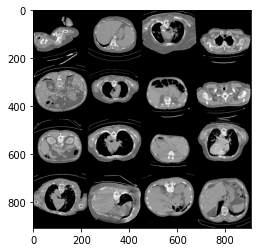

In [23]:
import torchvision
import matplotlib.pyplot as plt

grid_img = torchvision.utils.make_grid(batch, nrow=4,ncols=4)
plt.imshow(grid_img.permute(1, 2, 0))

In [24]:
from torch.utils.data.dataloader import DataLoader
train=dfloader(train_df.image.values,train_df.label.values,transform=aug)
val=dfloader(val_df.image.values,val_df.label.values,transform=aug)
train_loader = DataLoader(train,shuffle=True,num_workers=0,batch_size=512)
val_loader = DataLoader(val,shuffle=True,num_workers=0,batch_size=512)

In [25]:
device=torch.device('cuda')
model=model.to(device)
criterion = nn.BCEWithLogitsLoss()
opt=torch.optim.AdamW(params=model.parameters(),lr=0.001)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=2)

In [ ]:
res=fit(model,train_loader,val_loader,epoch=10,scheduler_step=True,verbose=True)

In [ ]:
state = {
        'epoch': 10,
        'state_dict': model.state_dict(),
        'optimizer': opt.state_dict(),
}
savepath='/content/drive/MyDrive/covid/mlp.pt'
torch.save(state,savepath)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/covid/mlp1.pt')